<a href="https://colab.research.google.com/github/Anna-Desorcy/ML_DDoS/blob/main/CPE400_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
DATASET_PATH = '/content/gdrive/MyDrive/CIC-DDoS2019_Dataset/'
! mkdir /content/data/
! cp -a {DATASET_PATH}. /content/data/

In [ ]:
import pandas as pd
import numpy as np

**We only have two classes in this dataset: Attack and Benign**

In [ ]:
def load_data(file):
  try:
    df = pd.read_csv(file)
    # map the class types into binary values
    d_class = {'Benign': 0, 'Attack': 1}
    df['Class'] = df['Class'].map(d_class)
    # two labels were the same but spelled differently,
    # so we had to change the names of the two to match each other
    df['Label'] = df['Label'].replace({'UDP-lag': 'UDP-Lag', 'UDPLag': 'UDP-Lag'})
    # delete first column b/c it just lists the sample number
    df = df.drop(columns=df.columns[0], axis=1)
    # df_short is a dataframe with 200,000 samples randomly chosen
    df_short = df.sample(200000)
    return df_short
  except FileNotFoundError:
    print(f'File: {file} not found.')
    return None

    # BALANCED VERSION
    # separate the data by class
    df_benign = df[df['Class'] == 0]
    df_attack = df[df['Class'] == 1]
    # take random sample of each class with equal size
    df_benign_short = df_benign.sample(200000)
    df_attack_short = df_attack.sample(200000)
    # combine the two dataframes
    df_short = pd.concat([df_benign_short, df_attack_short])
    return df_short
  except FileNotFoundError:
    print(f'File: {file} not found.')
    return None


In [ ]:
df = load_data('/content/data/cicddos2019_dataset.csv')

In [ ]:
# prompt: find amount of '0' in a column of dataframe

zeros = df['Class'].value_counts()[0]
print(f"Amount of '0' in 'Class' column: {zeros}")
ones = df['Class'].value_counts()[1]
print(f"Amount of '1' in 'Class' column: {ones}")

Amount of '0' in 'Class' column: 45458
Amount of '1' in 'Class' column: 154542


**We have 16 types of different attacks, the 17th being benign (no attack)**


1.   *DrDoS_DNS*
2.   *DrDoS_UDP*
3.   *Portmap*
4.   *NetBIOS*
5.   *UDP-Lag*
6.   *DrDoS_MSSQL*
7.   *DrDoS_SNMP*
8.   *DrDoS_NetBIOS*
9.   *TFTP*
10.  *DrDoS_LDAP*
11.  *Syn*
12.  *LDAP*
13.  *DrDoS_NTP*
14.  *UDP*
15.  *MSSQL*
16.  *WebDDOS*
17.  *Benign*




In [ ]:
features = []
for col in df.columns[1:-2]:
  features.append(col)
print(features)

['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Avg P

**We have 76 features in this dataset. We will need to do feature selection to find the minimum number of features and the important features required that yield high accuracy.**

In [ ]:
'''
Normalize Data: Z-Score
Google: 'The goal of normalization is to transform features to be on
a similar scale. This improves the performance and training stability
of the model.'
'''
def z_score(df):
  df_std = df.copy()
  for col in df_std.columns:
    if df_std[col].std() != 0:
      df_std[col] = (df_std[col] - df_std[col].mean()/df_std[col].std())
  return df_std


In [ ]:
labels = np.array(df['Label'])
classes = np.array(df['Class'])
df = df.drop(columns='Label')
df = df.drop(columns='Class')

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split

selector = SelectKBest(score_func=f_classif, k=10)
X_train, X_test, y_train, y_test = train_test_split(df, classes, test_size = 0.2)
X_train_standardized = z_score(X_train)
X_train_selected = selector.fit(X_train_standardized, y_train)

In [ ]:
f = X_train_selected.get_support()
selected_features = np.array(df.columns)[f]
score = selector.scores_[f]

In [ ]:
X_train_new = X_train.loc[:, selected_features]
X_test_new = X_test.loc[:, selected_features]

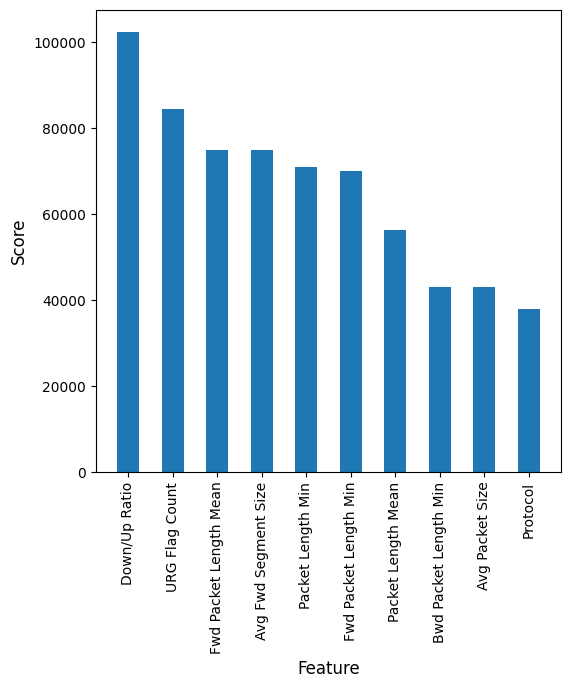

In [ ]:
import matplotlib.pyplot as plt

# Sort the features and scores in descending order

features_score_dict = dict(zip(selected_features,score))
sorted_features_scores = dict(sorted(features_score_dict.items(), key=lambda item: item[1], reverse=True))
keys = list(sorted_features_scores.keys())      # Feature names
values = list(sorted_features_scores.values())  # Score: Higher score means more importance to system's decision process

# Create the bar plot
plt.figure(figsize=(6, 6))
plt.bar(keys, values, width=0.5)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_new,y_train)

model_rf = RandomForestClassifier()
model_rf.fit(X_train_new,y_train)

model_knn = KNeighborsClassifier()
model_knn.fit(X_train_new,y_train)

model_p = Perceptron()
model_p.fit(X_train_new,y_train)

model_nn = MLPClassifier()
model_nn.fit(X_train_new,y_train)

MLPClassifier()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# TOP LEFT: True Negative
# TOP RIGHT: False Negative
# BOTTOM LEFT: False Positive
# BOTTON RIGHT: True Positive
def compute_matrix(ground_truth, prediction):
  cm = confusion_matrix(ground_truth,prediction)

  plt.figure(figsize=(4, 2))
  sns.heatmap(cm, annot=True, cmap='Oranges', fmt='d', xticklabels=['0', '1'], yticklabels=['0', '1'])
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

99.38749999999999 %


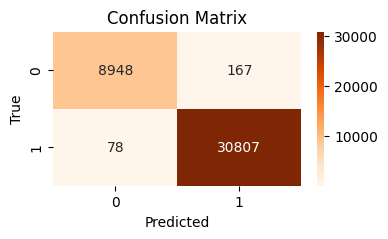

In [ ]:
# DECISION TREE ACCURACY
pred = model_dt.predict(X_test_new)
accuracy = accuracy_score(y_test,pred)*100
print(accuracy,'%')
cm = compute_matrix(y_test,pred)

99.4175 %


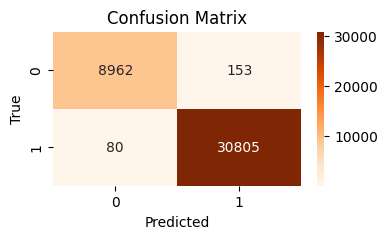

In [ ]:
# RANDOM FOREST ACCURACY
pred = model_rf.predict(X_test_new)
accuracy = accuracy_score(y_test,pred)*100
print(accuracy,'%')
cm = compute_matrix(y_test,pred)

99.36500000000001 %


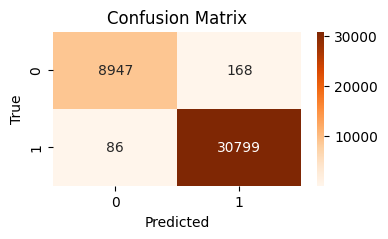

In [ ]:
# KNN ACCURACY
pred = model_knn.predict(X_test_new)
accuracy = accuracy_score(y_test,pred)*100
print(accuracy,'%')
cm = compute_matrix(y_test,pred)

96.53500000000001 %


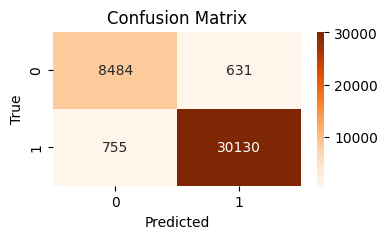

In [ ]:
# PERCEPTRON ACCURACY
pred = model_p.predict(X_test_new)
accuracy = accuracy_score(y_test,pred)*100
print(accuracy,'%')
cm = compute_matrix(y_test,pred)

99.2725 %


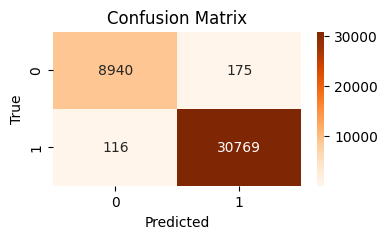

In [ ]:
# NEURAL NETWORK ACCURACY
pred = model_nn.predict(X_test_new)
accuracy = accuracy_score(y_test,pred)*100
print(accuracy,'%')
cm = compute_matrix(y_test,pred)